In [321]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from typing import Tuple
import cv2

In [322]:
images = {
    "christmas_tree_6000x4000": "images/christmas_tree_6000x4000.png",
    "christmas_tree_600x400": "images/christmas_tree_600x400.png",
    "lenna_512x512": "images/lenna_512x512.png",
    "lenna_256x256": "images/lenna_256x256.png",
    "lenna_128x128": "images/lenna_128x128.png",
    "lenna_64x64": "images/lenna_64x64.png",
    "lenna_32x32": "images/lenna_32x32.png",
    "Barns_grand_tetons_1600x1195": "images/Barns_grand_tetons_1600x1195.png",
}


In [323]:
# image which should be encoded
image_path = images["lenna_512x512"]

# jpeg parameters
block_size: int = 8
subsampling_settings: Tuple[int, int, int] = (4, 2, 0)
quantization_table_quality: int = 10  # can be one of: (100, 90, 50, 10) 

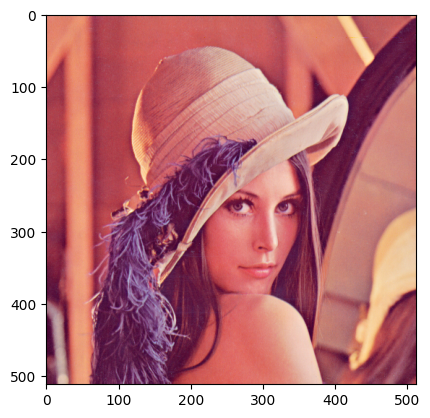

In [324]:
image = plt.imread(image_path)

fig, ax = plt.subplots()
ax.imshow(image, cmap="gray")

In [325]:
def plot_y_u_v(y_loc, u_loc, v_loc, colormap=True):
    fig_loc, ax_loc = plt.subplots(1, 3, figsize=(15, 20))
    ax_loc[0].imshow(y_loc, cmap="gray")
    ax_loc[0].set_title("Y Component")

    # creating a linear colormap, based on the values of the example https://commons.wikimedia.org/wiki/File:Barn-yuv.png
    if colormap:
        cmap_u = matplotlib.colors.LinearSegmentedColormap.from_list("", [(0, 177/255, 78/255, 1), (0, 86/255, 169/255, 1)])
    else:
        cmap_u = matplotlib.colormaps["gray"]
    ax_loc[1].imshow(u_loc, cmap=cmap_u)
    ax_loc[1].set_title("U Component")

    if colormap:
        cmap_v = matplotlib.colors.LinearSegmentedColormap.from_list("", [(104/255, 151/255, 0, 1), (171/255, 84/255, 0)])
    else:
        cmap_v = matplotlib.colormaps["gray"]
    ax_loc[2].imshow(v_loc, cmap=cmap_v)
    ax_loc[2].set_title("V Component")
    plt.show()

In [326]:
def get_matrix(size=8):
    matr = []
    for i in range(size):
        matr.append(np.array(range(i * size, (i + 1) * size)))
    matr = np.array(matr)
    print(matr)

## Step 1 
### Colorspace Transformation

In [327]:
from jpeg_implementation.rgbToYuv import rgb_to_yuv

In [328]:
y, u, v = rgb_to_yuv(image=image)

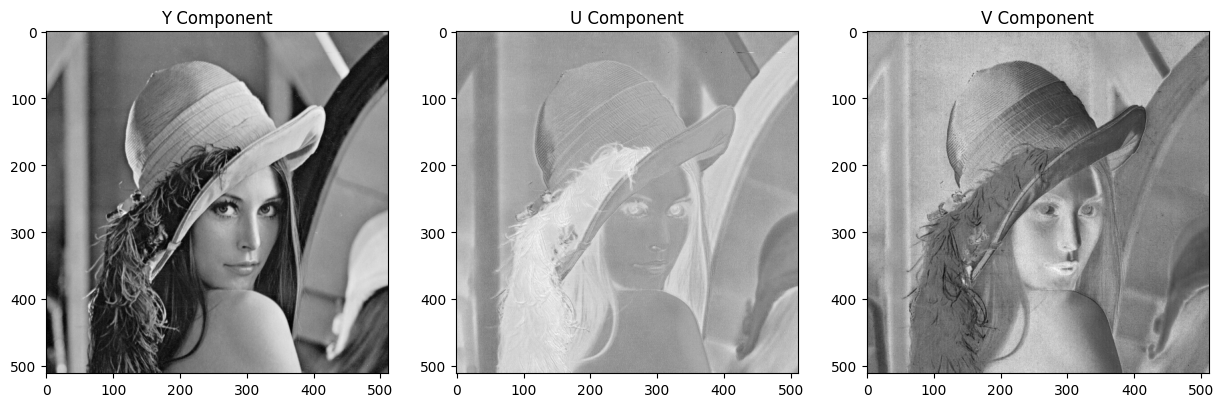

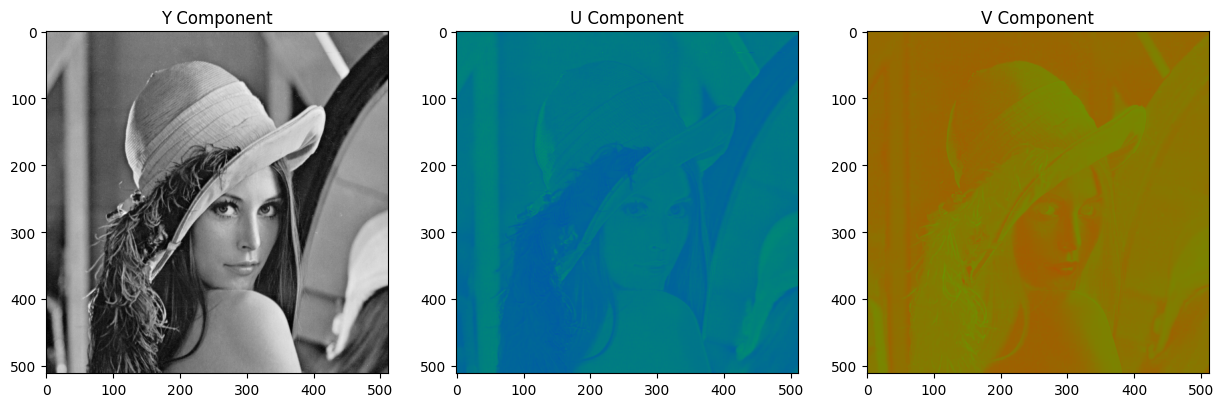

In [329]:
plot_y_u_v(y, u, v, colormap=False)
plot_y_u_v(y, u, v)


## Step 2 
### Subsampling of Color Components

In [330]:
from jpeg_implementation.subsample import subsample_u_v

In [331]:
u_subs, v_subs = subsample_u_v(u, v, *subsampling_settings)


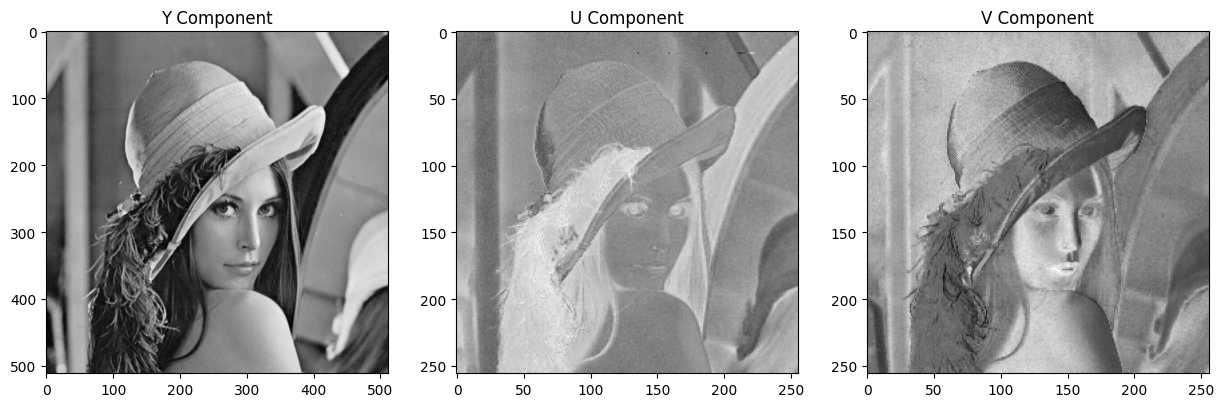

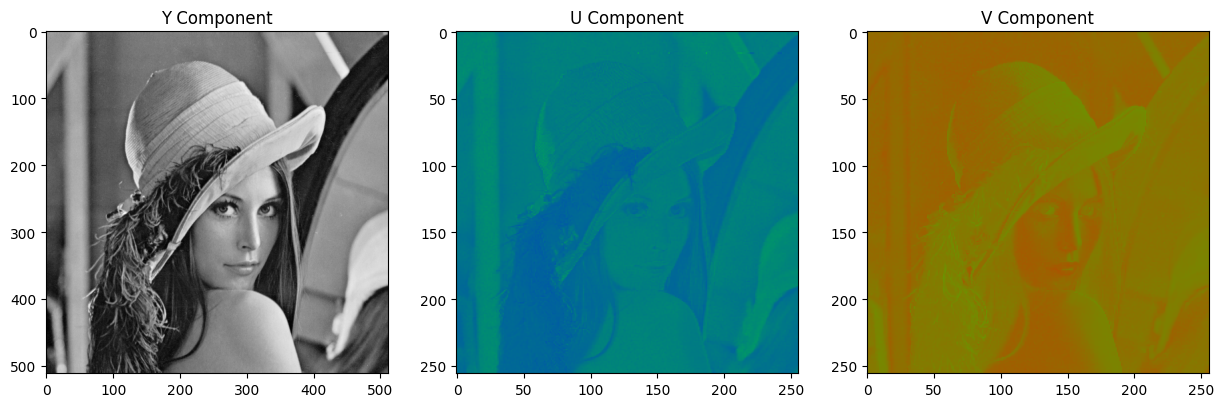

In [332]:
plot_y_u_v(y, u_subs, v_subs, colormap=False)
plot_y_u_v(y, u_subs, v_subs)


## Step 3
### Split into 8x8 Blocks

In [333]:
from jpeg_implementation.splitBlocks import split

In [334]:
split_y = split(y, block_size)
split_u = split(u_subs, block_size)
split_v = split(v_subs, block_size)


## Step 3
### Apply dct

In [335]:
from jpeg_implementation.dct import block_dct2

In [336]:
trans_y = block_dct2(np.array(split_y) - 128, block_size)
trans_u = block_dct2(np.array(split_u) - 128, block_size)
trans_v = block_dct2(np.array(split_v) - 128, block_size)


## Step 4 
### Quantization


In [337]:
from jpeg_implementation.quantization import quantize, quantization_tables

quantization_table = quantization_tables[quantization_table_quality]

quantized_y = quantize(trans_y, quantization_table)
quantized_u = quantize(trans_u, quantization_table)
quantized_v = quantize(trans_v, quantization_table)

## Step 5
### Reordering of values, Run Length Encoding

In [338]:
from jpeg_implementation.runLengthEncode import resort_and_run_length_encode

In [339]:
rl_encoded_y = resort_and_run_length_encode(quantized_y, block_size)
rl_encoded_u = resort_and_run_length_encode(quantized_u, block_size)
rl_encoded_v = resort_and_run_length_encode(quantized_v, block_size)


In [340]:
print(len(rl_encoded_y), len(rl_encoded_u), len(rl_encoded_v))
print(rl_encoded_u[0])
print(rl_encoded_v[0])

31198 4644 5364
-2.0
6.0


## Step 6
### Huffman Encoding

In [341]:
from jpeg_implementation.huffman import generate_huffman_code, encode_huffman

data = rl_encoded_y + rl_encoded_u + rl_encoded_v
huffman_code = generate_huffman_code(data)
encoded = encode_huffman(huffman_code, data)
print("original", len(data * 8), "bits")
print("encoded", len(encoded), "bits")
print("encoded + table", len(encoded) + len(huffman_code) * 16, "bits")
print("compression ratio", len(data * 8) / len(encoded))

original 329648 bits
encoded 136048 bits
encoded + table 136752 bits
compression ratio 2.4230271668822767


In [342]:
huffman_code_y = generate_huffman_code(rl_encoded_y)
huff_encoded_y = encode_huffman(huffman_code_y, rl_encoded_y)

huffman_code_u = generate_huffman_code(rl_encoded_u)
huff_encoded_u = encode_huffman(huffman_code_u, rl_encoded_u)

huffman_code_v = generate_huffman_code(rl_encoded_v)
huff_encoded_v = encode_huffman(huffman_code_v, rl_encoded_v)

print("y", len(huff_encoded_y), "bits")
print("u", len(huff_encoded_u), "bits")
print("v", len(huff_encoded_v), "bits")
print("encoded", len(huff_encoded_y) + len(huff_encoded_u) + len(huff_encoded_v), "bits")
print("compression ratio", len(data * 8) / (len(huff_encoded_y) + len(huff_encoded_u) + len(huff_encoded_v)))

y 103866 bits
u 12826 bits
v 16382 bits
encoded 133074 bits
compression ratio 2.477178111426725


## Step 7
### Serialization

In [343]:
from jpeg_implementation.serialize import bitstring_to_bytes, bytes_to_bitstring

# convert huffman encoded bits to bytes
byte_string, prepended_bits = bitstring_to_bytes(encoded)

# write bytes to file 
with open("compressed.imagedata", "wb") as fp:
    fp.write(byte_string)

# read file
with open("compressed.imagedata", "rb") as fp:
    read_bytes = fp.read()

# decode bytes to bitstring
encoded_from_file = bytes_to_bitstring(read_bytes, prepended_bits)

# compare 
print(len(byte_string), "bytes of image data", "prepended_bits:", prepended_bits)
print(len(encoded), len(encoded_from_file))
print(encoded == encoded_from_file)


17006 bytes of image data prepended_bits: 0
136048 136048
True


In [344]:
# build header of file
# first a number of fixed size that defines header length (length of encoded data of encoding tables)
# maybe for each component (y u v) depending on if huffman is encoded for every component or together
# then the number of fixed size describing the length of the image data 

In [345]:
from jpeg_implementation.serialize import dict_to_bytes, bytes_to_dict


In [346]:
dict_bytes = dict_to_bytes(huffman_code)
print(len(dict_bytes), type(dict_bytes))
with open("huffman.code", "wb") as fp:
    fp.write(dict_bytes)

with open("huffman.code", "rb") as fp:
    dict_bytes_file = fp.read()
    reassembled = bytes_to_dict(dict_bytes_file)

print(reassembled == huffman_code)
print(dict_bytes)

306 <class 'bytes'>
True
b'63:H,50:I0F,57:I0G0y5:I0H0,6:I0I0,5:Ip,54:IriH,I:IriI0H,R:IriI0Ir,39:IriI0Ii,44:IriIqI,14:IriIn,53:IriIpi1,12:IriIph,47:IriIri,46:IriIi,56:IriRy7:Irhy2:Ii1y3:Ih1y4:Ig1y8:If,0:R,2zH,58zI0I,64zIp,51zIri1,8zIrh,62zIi1,7zIh1y9zIgG,52zIgH0,60zIgIr,45zIgIi,49zIgQ,9zIg1iy6zIf,3:qI,55:oH,59:oI0,61:m,4:piy1:ri,1:i'
